In [2]:
import pandas as pd
import janitor as jn
import pymc3 as pm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
df = pd.read_csv('../data/finch_beaks_2012.csv')
df = (jn.DataFrame(df)
      .clean_names()
      .rename_column('blenth', 'beak_length')
      .rename_column('bdepth', 'beak_depth')
      .encode_categorical('species')
     )
df.groupby('species').size()

species
fortis      121
scandens    127
unknown       1
dtype: int64

Ignore the "unknown" bird for now.

In [4]:
df.dtypes

band             int64
species       category
blength        float64
beak_depth     float64
dtype: object

In [5]:
fortis_filter = df['species'] == 'fortis'
scandens_filter = df['species'] == 'scandens'

In [6]:
with pm.Model() as beak_depth_model:
    fortis_mean = pm.Normal('fortis_mean', mu=0, sd=100)
    scandens_mean = pm.Normal('scandens_mean', mu=0, sd=100)
    
    fortis_sd = pm.HalfCauchy('fortis_sd', beta=100)
    scandens_sd = pm.HalfCauchy('scandens_sd', beta=100)
    
    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    like_fortis = pm.StudentT('like_fortis', mu=fortis_mean, sd=fortis_sd, nu=nu,
                              observed=df[fortis_filter]['beak_depth'])
    like_scandens = pm.StudentT('like_scandens', mu=scandens_mean, sd=scandens_sd, nu=nu,
                                 observed=df[scandens_filter]['beak_depth'])

In [11]:
with beak_depth_model:
    trace = pm.sample(2000, tuning=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, scandens_sd_log__, fortis_sd_log__, scandens_mean, fortis_mean]
100%|██████████| 2500/2500 [00:07<00:00, 316.27it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


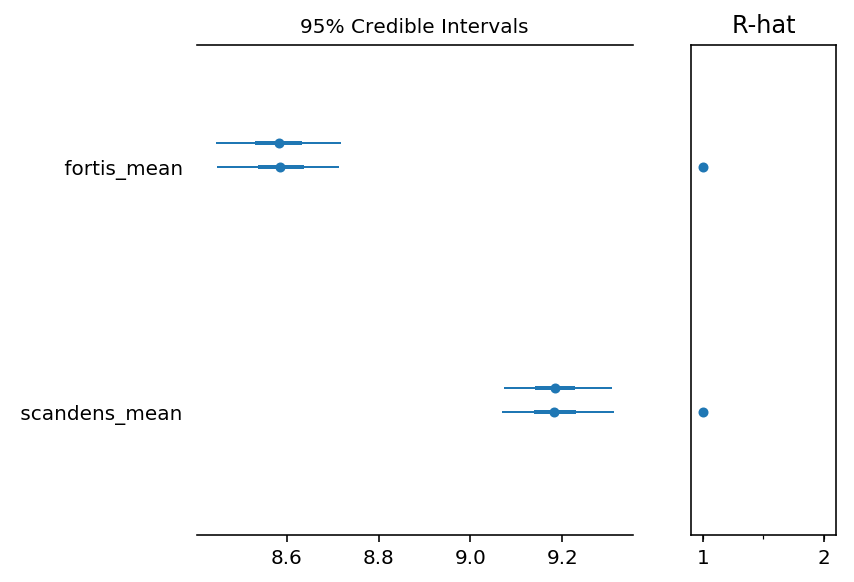

In [12]:
pm.forestplot(trace, varnames=['fortis_mean', 'scandens_mean'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10b036208>,
      dtype=object)

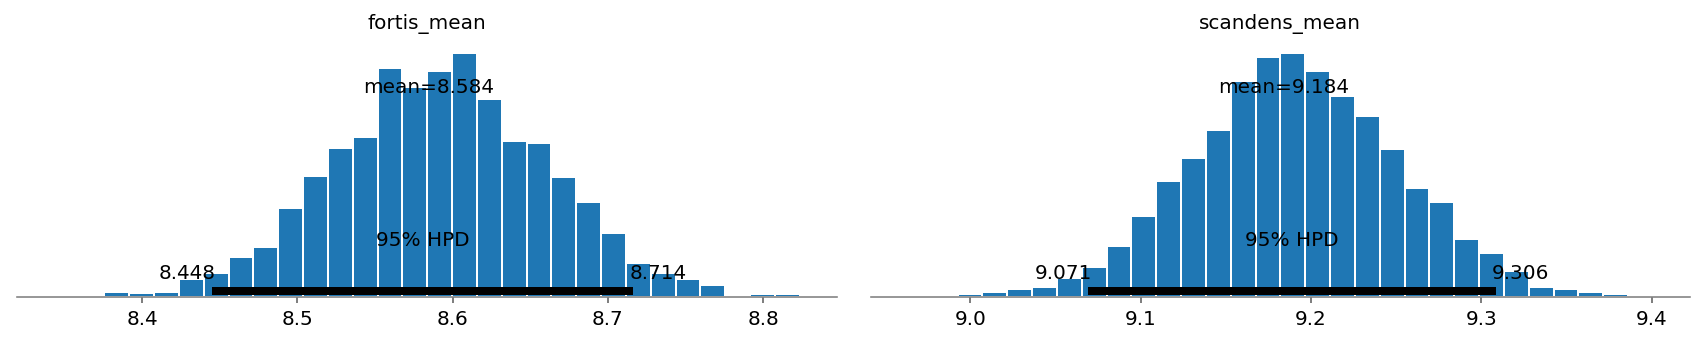

In [13]:
pm.plot_posterior(trace, varnames=['fortis_mean', 'scandens_mean'])